# Mapping chemically peculiar stars
This is a work in progress.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
import theano.tensor as tt

In [4]:
# Generate a random map from a decaying power spectrum
np.random.seed(43)
ydeg = 10
power = np.array([0.002 * np.exp(-(l / 3.0) ** 2) for l in range(1, ydeg + 1) for m in range(-l, l + 1)])
y = np.random.randn((ydeg + 1) ** 2 - 1) * np.sqrt(power)

# True values
truths = {
    "inc":      60.0,
    "period":   8.53,
    "y":        y,
    "power":    power,
    "flux_err": 0.001
}

# Generate a synthetic dataset
t = np.linspace(0, 27, 300)
map = starry.Map(ydeg=ydeg)
map[1:, :] = truths["y"]
map.inc = truths["inc"]
theta = 360. * t / truths["period"]

# Compute the design matrix and dot `y` in to get the flux
# Recall that the y[0] term is *fixed* at unity, so we need
# to treat it separately by breaking up the design matrix.
X = map.linear_op(theta=theta)
truths["flux"] = (X[:, 0] + tt.dot(X[:, 1:], y)).eval()

# Add noise
np.random.seed(44)
flux = truths["flux"] + truths["flux_err"] * np.random.randn(len(t))

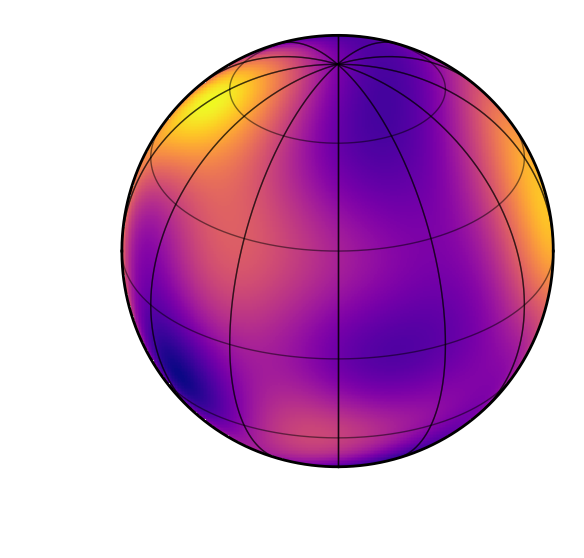

In [ ]:
map.show()

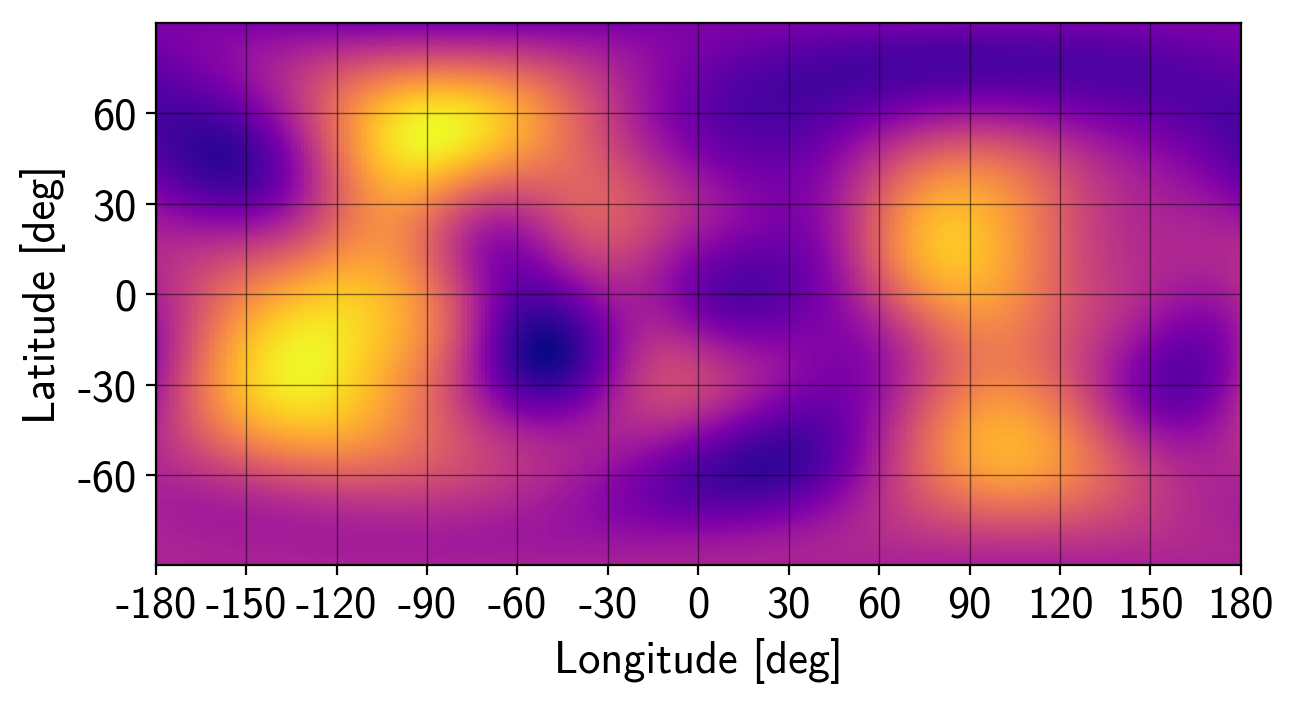

In [ ]:
map.show(projection="rect")

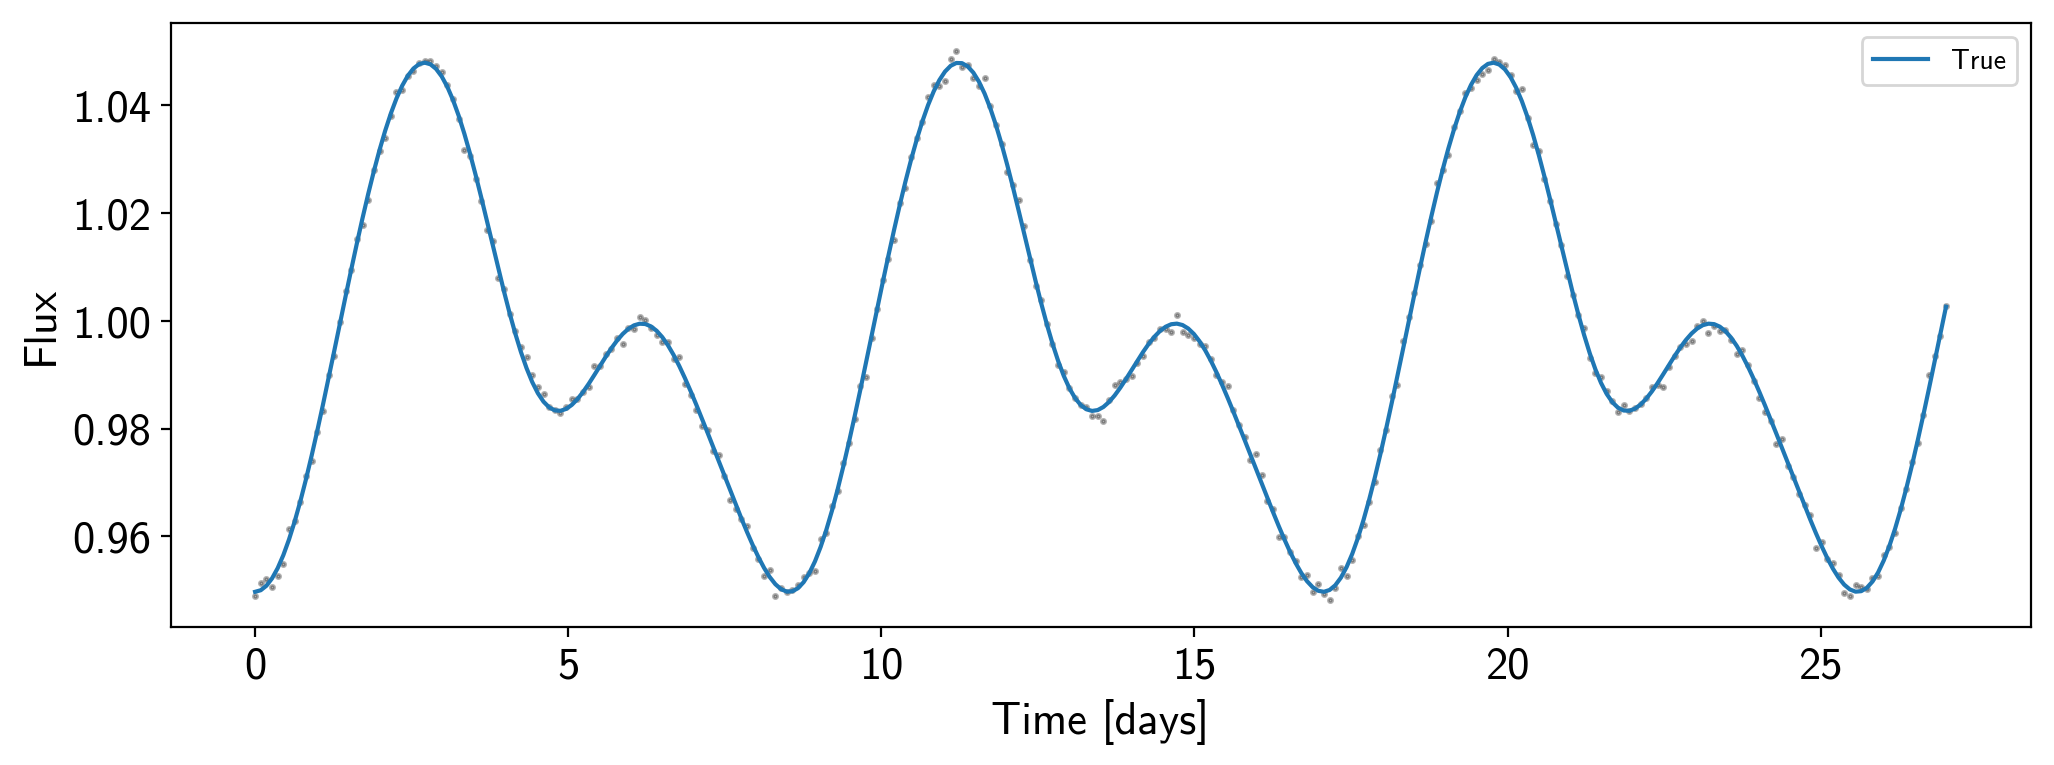

In [ ]:
# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

In [ ]:
# Define our model
map = starry.Map(ydeg=ydeg)
with pm.Model() as model:

    # Priors on the things we're solving for
    period = pm.Uniform("period", 8.4, 8.6)
    inc = pm.Uniform("inc", 50, 90)
     
    # Compute the model using starry
    theta = 360.0 * t / period
    XFull = map.linear_op(theta=theta, inc=inc)
    X0 = XFull[:, 0]
    X = XFull[:, 1:]
    
    # Solve the least squares problem
    XT = X.T / truths["flux_err"] ** 2
    XTX = tt.dot(XT, X)
    LInv = np.diag(1.0 / power)
    W = XTX + LInv
    
    # Cholesky decomposition
    cho_solve_lower = tt.slinalg.Solve(A_structure='lower_triangular', lower=True)
    cho_solve_upper = tt.slinalg.Solve(A_structure='upper_triangular', lower=False)
    cho_W = tt.slinalg.cholesky(W)
    Q = cho_solve_lower(cho_W, XT)
    M = cho_solve_upper(cho_W.T, Q)
    y = tt.dot(M, flux - X0)
    
    # Get the MAP flux model
    flux_model = (X0 + tt.dot(X, y))
    
    # L2 penalty. CHECK: Is this term required, as we're solving for `y` above?
    pm.Normal("L2", mu=0, sd=power, observed=y)
    
    # Correction for marginal likelihood
    pm.Potential("marginal", -tt.sum(tt.log(tt.diag(cho_W))))
    
    # Track some values for plotting later
    pm.Deterministic("flux_model", flux_model)
    pm.Deterministic("y", y)

    # Save our initial guess
    model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=truths["flux_err"], observed=flux)

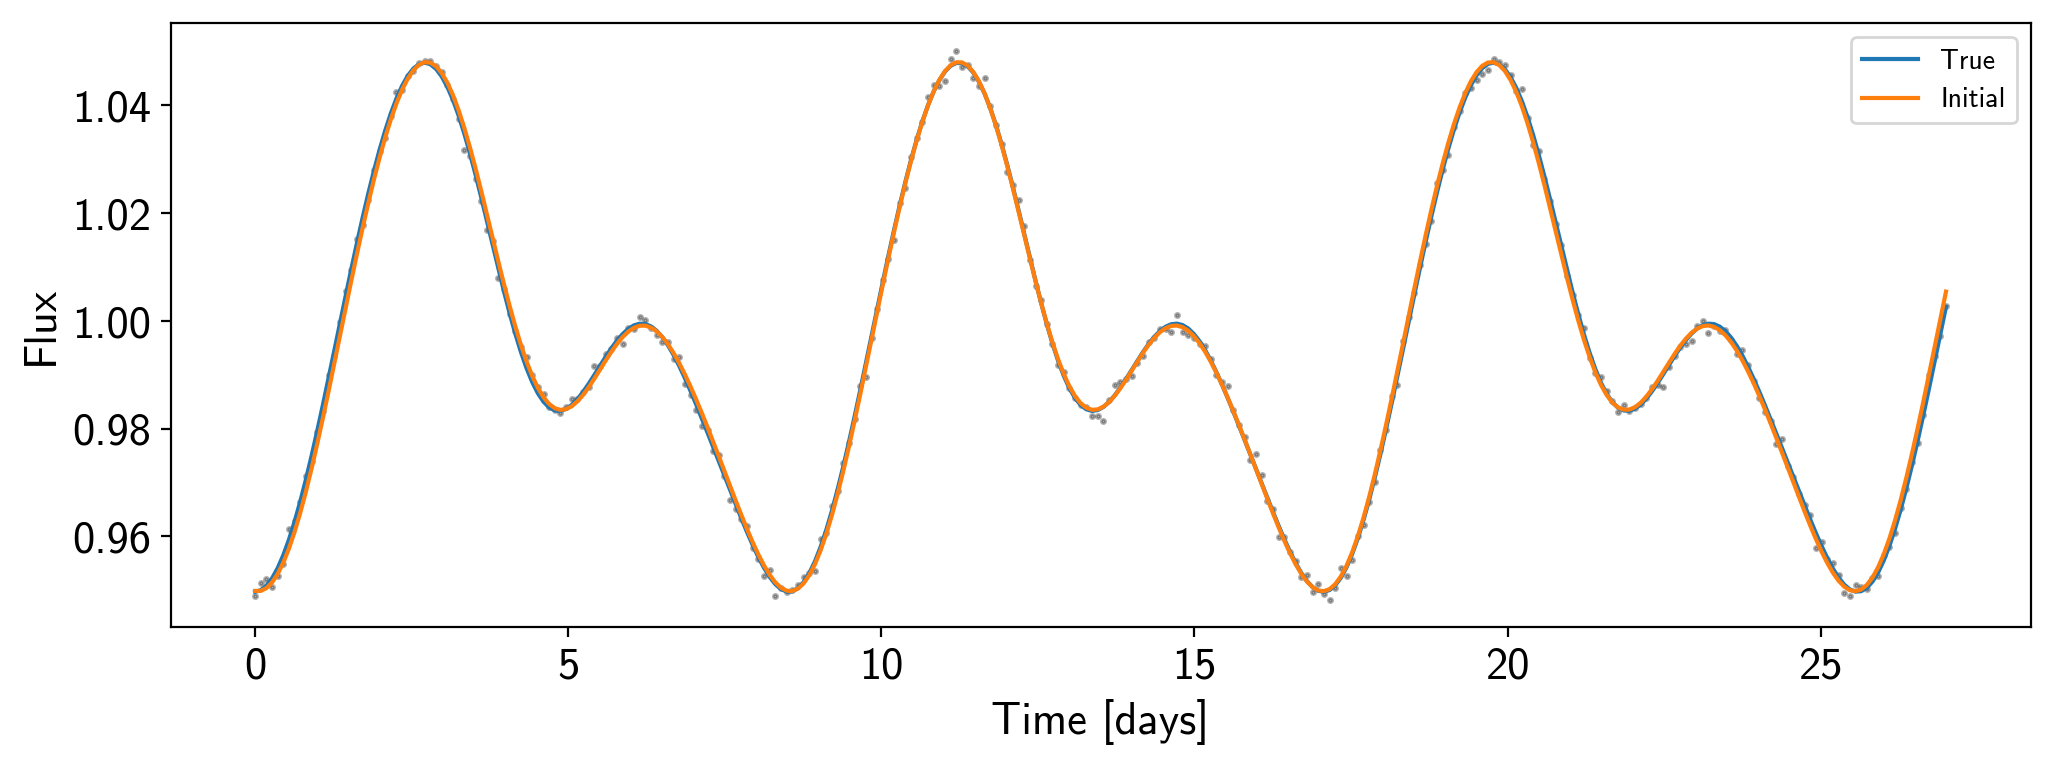

In [ ]:
# Plot it
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, flux, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["flux"], label="True")
ax.plot(t, model_guess, label="Initial")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("Flux");

In [ ]:
# Sample it
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=375, start=model.test_point, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=1000)

/mnt/home/rluger/anaconda3/lib/python3.6/site-packages/Theano-1.0.4-py3.6.egg/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/mnt/home/rluger/anaconda3/lib/python3.6/site-packages/Theano-1.0.4-py3.6.egg/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/mnt/home/rluger/anaconda3/lib/python3.6/site-packages/Theano-1.0.4-py3.6.egg/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is de

In [ ]:
varnames = ["period", "inc"]
pm.summary(trace, varnames=varnames)

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples, truths=[truths["period"], truths["inc"]]);